In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
for module in np, pd, tf:
     print (module.__name__, module.__version__)

numpy 1.21.4
pandas 1.3.4
tensorflow 2.7.0


In [3]:
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
stock = pd.read_csv('../dataset/sh600031.csv')  # 读取股票文件

# 增添一列T+1涨跌数据

In [5]:
datalist = list()
# 上市第一天都设为涨
datalist.append(1)
for i in range(1,len(stock)):
    if stock.iloc[i,list(stock.columns).index('close')]>stock.iloc[i-1,list(stock.columns).index('close')]:
        datalist.append(1)
    else :
        datalist.append(0)
stock['chan'] = datalist


In [6]:
stock.head()

,date,open,high,low,close,volume,chan
0,2003-07-03,23.00,23.00,20.10,21.30,33816715,1
1,2003-07-04,21.30,22.18,21.05,21.84,7697544,1
2,2003-07-07,21.90,21.96,21.51,21.80,3951205,0
3,2003-07-08,21.80,22.22,21.70,21.91,2117357,1
4,2003-07-09,21.75,22.65,21.70,22.47,3440447,1


In [7]:
# 取除日期外全部特征
training_set = stock.iloc[0:int(len(stock) / 5 * 4), 1:]
test_set = stock.iloc[int(len(stock) / 5 * 4):, 1:]

In [8]:
training_set.shape , test_set.shape

((3539, 6), (885, 6))

In [9]:
training_set = training_set.values
test_set = test_set.values

# 归一化处理（进行缩放）

In [10]:
# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
# 缩放
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

In [11]:
test_set

array([[0.05522682, 0.05507641, 0.05927126, 0.05862832, 0.07466331,
        1.        ],
       [0.05689577, 0.05916175, 0.0617004 , 0.06257901, 0.13024207,
        1.        ],
       [0.05947504, 0.06022091, 0.06445344, 0.06352718, 0.11363668,
        1.        ],
       ...,
       [0.27901684, 0.27674383, 0.28987854, 0.28334387, 0.14002392,
        0.        ],
       [0.27218935, 0.27507944, 0.2859919 , 0.28603034, 0.13212227,
        1.        ],
       [0.27279624, 0.27583598, 0.2897166 , 0.28223767, 0.10478023,
        0.        ]])

In [12]:
# 参数设置
# 步进值
seq_len = 1

#  训练集处理

In [13]:
x_train = []
y_train = []

# 数据进行分组
for i in range(seq_len, len(training_set_scaled)):
    # 全部特征
    x_train.append(training_set_scaled[i - seq_len:i, 0:])
    # T+1的涨跌幅
    y_train.append(training_set_scaled[i, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('chan')])

# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], seq_len, training_set.shape[1]))

# 测试集处理

In [14]:
x_test = []
y_test = []

# 利用for循环，遍历整个测试集，提取测试集中连续5天的开盘价作为输入特征x_train，第6天的数据作为标签
for i in range(seq_len, len(test_set)):
    # 全部特征
    x_test.append(test_set[i - seq_len:i, 0:])
    # T+1的涨跌幅
    y_test.append(test_set[i, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('chan')])

    # 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], seq_len, test_set.shape[1]))

In [15]:
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mean_squared_error')  
# 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

In [17]:
checkpoint_save_path = "./checkpoint/rnn_stock.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

-------------load the model-----------------


In [18]:
# 训练参数
batch_size = 64
epochs = 100
validation_freq=1
# 等等

Epoch 1/100
56/56 [==============================] - 5s 22ms/step - loss: 0.2843 - val_loss: 0.2590
Epoch 2/100
56/56 [==============================] - 1s 11ms/step - loss: 0.2541 - val_loss: 0.2557
Epoch 3/100
56/56 [==============================] - 1s 11ms/step - loss: 0.2525 - val_loss: 0.2530
Epoch 4/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2510 - val_loss: 0.2531
Epoch 5/100
56/56 [==============================] - 1s 10ms/step - loss: 0.2524 - val_loss: 0.2521
Epoch 6/100
56/56 [==============================] - 0s 8ms/step - loss: 0.2506 - val_loss: 0.2519
Epoch 7/100
56/56 [==============================] - 0s 8ms/step - loss: 0.2516 - val_loss: 0.2517
Epoch 8/100
56/56 [==============================] - 0s 7ms/step - loss: 0.2528 - val_loss: 0.2546
Epoch 9/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2516 - val_loss: 0.2513
Epoch 10/100
56/56 [==============================] - 0s 7ms/step - loss: 0.2509 - val_loss: 0.2511
Epoch

Epoch 83/100
56/56 [==============================] - 0s 5ms/step - loss: 0.2507 - val_loss: 0.2524
Epoch 84/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2516 - val_loss: 0.2514
Epoch 85/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2504 - val_loss: 0.2515
Epoch 86/100
56/56 [==============================] - 0s 5ms/step - loss: 0.2502 - val_loss: 0.2504
Epoch 87/100
56/56 [==============================] - 0s 5ms/step - loss: 0.2501 - val_loss: 0.2513
Epoch 88/100
56/56 [==============================] - 0s 5ms/step - loss: 0.2509 - val_loss: 0.2533
Epoch 89/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2505 - val_loss: 0.2501
Epoch 90/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2506 - val_loss: 0.2504
Epoch 91/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2498 - val_loss: 0.2524
Epoch 92/100
56/56 [==============================] - 0s 6ms/step - loss: 0.2509 - val_loss: 0.2550


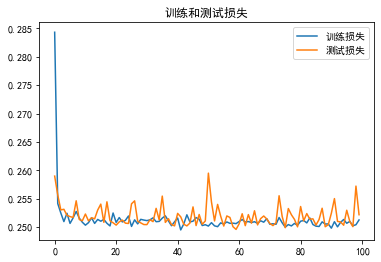

In [19]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), validation_freq=validation_freq,
                   callbacks=[cp_callback])

model.summary()

file = open('./weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = _model.history['loss']
val_loss = _model.history['val_loss']

plt.plot(loss, label='训练损失')
plt.plot(val_loss, label='测试损失')
plt.title('训练和测试损失')
plt.legend()
plt.show()

In [20]:
# 预测
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

In [21]:
# 归一时是对所有数据列进行的归一
# 补充数据列之后才能进行反归一
predicted_df = pd.DataFrame(test_set[seq_len:])
predicted_df.iloc[:, list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('chan')] = predicted_stock_price
predicted_set = predicted_df.values
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_set)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[seq_len:])

In [22]:
predicted_stock_price

array([[8.36000000e+00, 8.62000000e+00, 8.36000000e+00, 8.59000000e+00,
        1.12531094e+08, 4.66994107e-01],
       [8.53000000e+00, 8.69000000e+00, 8.53000000e+00, 8.65000000e+00,
        9.81910050e+07, 4.65172410e-01],
       [8.65000000e+00, 8.72000000e+00, 8.50000000e+00, 8.51000000e+00,
        5.29614480e+07, 4.65829760e-01],
       ...,
       [2.30000000e+01, 2.30000000e+01, 2.24500000e+01, 2.25600000e+01,
        1.20978513e+08, 4.73224312e-01],
       [2.25500000e+01, 2.28900000e+01, 2.22100000e+01, 2.27300000e+01,
        1.14154802e+08, 4.70604181e-01],
       [2.25900000e+01, 2.29400000e+01, 2.24400000e+01, 2.24900000e+01,
        9.05427410e+07, 4.77671534e-01]])

In [23]:
# 只取涨跌幅
real_stock_price = test_set[seq_len:][:,list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('chan')]
predicted_stock_price = predicted_set[:,list(stock.iloc[0:int(len(stock) / 5 * 4), 1:].columns).index('chan')]

In [24]:
predicted_stock_price

array([0.46699411, 0.46517241, 0.46582976, 0.46241868, 0.46040818,
       0.4622612 , 0.46726933, 0.46148854, 0.46766308, 0.46728969,
       0.46391577, 0.46774286, 0.46024472, 0.46726227, 0.4616659 ,
       0.46668991, 0.46188685, 0.4663451 , 0.46605158, 0.46719605,
       0.46263862, 0.46152985, 0.4679108 , 0.46503568, 0.46198916,
       0.4625507 , 0.46731502, 0.46111351, 0.461878  , 0.46173799,
       0.46141151, 0.46756703, 0.46833241, 0.46762329, 0.46132961,
       0.46677822, 0.46692696, 0.46730846, 0.4670091 , 0.46713758,
       0.46246633, 0.46206897, 0.46751624, 0.46093953, 0.46063268,
       0.46130472, 0.46640405, 0.45604187, 0.46036631, 0.46393082,
       0.4645499 , 0.46003723, 0.45946741, 0.45997962, 0.46155205,
       0.46576893, 0.45998445, 0.46568015, 0.45846966, 0.46099678,
       0.45980677, 0.46721572, 0.46740437, 0.46233147, 0.46670082,
       0.46806264, 0.46243495, 0.46242851, 0.46788359, 0.46648377,
       0.46794242, 0.46574792, 0.46056947, 0.46477541, 0.46171

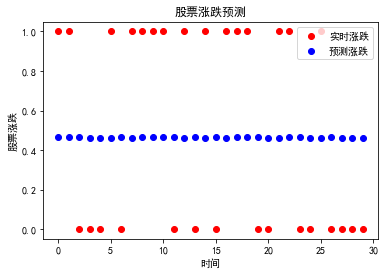

In [34]:
# 画出真实数据和预测数据的对比曲线
x = real_stock_price[:30]
y = predicted_stock_price[:30]
plt.scatter(list(range(len(x))),x,c='red',label='实时涨跌')
plt.scatter(list(range(len(y))),y,c='blue',label='预测涨跌')
plt.title('股票涨跌预测')
plt.xlabel('时间')
plt.ylabel('股票涨跌')
plt.legend()
plt.show()

In [26]:
# 评估
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.252181
均方根误差: 0.502176
平均绝对误差: 0.501335


In [27]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predicted_stock_price[i] - real_stock_price[i])
    summery += real_stock_price[i]
acc = 1 - error/summery
print("准确率：{}".format(acc))

准确率：0.13199487541403088
